**Task: Building a Neural Network from Scratch**

---



Importing libraries and dataset:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

dataset = pd.read_csv("data.csv")
dataset.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,206.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,0,0,0,0,0,0,3,0,0,...,128.0,106.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data preprocessing:



In [ ]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

# Extract features and labels
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

# Normalize the features
X = X / 255.0
X = np.hstack((np.ones((X.shape[0], 1)), X)) #add a column of ones to the start of X, increasing its second dimension from 784 to 785

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y = y.reshape(-1, 1)
y = encoder.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**Creating Neural Network**

---

In [ ]:
class NeuralNetwork:
    def __init__(self, input_dim, output_dim):
        np.random.seed(13)
        n_input = 785  # Input layer size (pixel1 to pixel 784 + bias)
        n_hidden1 = 128  # Hidden layer 1 size
        n_hidden2 = 64  # Hidden layer 2 size
        n_hidden3 = 32  # Hidden layer 3 size
        n_output = 10  # Output layer size (#classes)
        self.weights = {
          'h1': np.random.randn(n_input, n_hidden1)*0.01,
          'h2': np.random.randn(n_hidden1, n_hidden2)*0.01,
          'h3': np.random.randn(n_hidden2, n_hidden3)*0.01,
          'out': np.random.randn(n_hidden3, n_output)*0.01
        }

        self.biases = {
          'h1': np.zeros((1, n_hidden1)),
          'h2': np.zeros((1, n_hidden2)),
          'h3': np.zeros((1, n_hidden3)),
          'out': np.zeros((1, 10))
        }

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)  # limit the values to prevent overflow
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        e_power_x = np.exp(x- np.max(x,axis=1,keepdims=True))
        return e_power_x / np.sum(e_power_x, axis=1, keepdims=True)

    def cross_entropy(self, y, y_hat):
        return -np.sum(y * np.log(y_hat))

    def forward_pass(self, X):
        # Hidden layer 1
        z1 = np.dot(X, self.weights['h1']) + self.biases['h1']
        a1 = self.sigmoid(z1)

        # Hidden layer 2
        z2 = np.dot(a1, self.weights['h2']) + self.biases['h2']
        a2 = self.sigmoid(z2)

        # Hidden layer 3
        z3 = np.dot(a2, self.weights['h3']) + self.biases['h3']
        a3 = self.sigmoid(z3)

        # Output layer
        z_out = np.dot(a3, self.weights['out']) + self.biases['out']
        y_hat = self.softmax(z_out)

        # Store the intermediate results for use in backpropagation
        self.intermediates = {'a1': a1, 'a2': a2, 'a3': a3, 'y_hat': y_hat}

        return y_hat

    def backward_pass(self, X, y, y_hat):
        # Output layer
        delta_out = y_hat - y

        # Hidden layer 3
        delta_3 = np.dot(delta_out, self.weights['out'].T) * (self.intermediates['a3'])

        # Hidden layer 2
        delta_2 = np.dot(delta_3, self.weights['h3'].T) * (self.intermediates['a2'])

        # Hidden layer 1
        delta_1 = np.dot(delta_2, self.weights['h2'].T) * (self.intermediates['a1'])

        # Store the gradients for use in updating the weights and biases
        self.gradients = {'w_out': np.dot(self.intermediates['a3'].T, delta_out), 'b_out': np.sum(delta_out, axis=0),
                          'w_h3': np.dot(self.intermediates['a2'].T, delta_3), 'b_h3': np.sum(delta_3, axis=0),
                          'w_h2': np.dot(self.intermediates['a1'].T, delta_2), 'b_h2': np.sum(delta_2, axis=0),
                          'w_h1': np.dot(X.T, delta_1), 'b_h1': np.sum(delta_1, axis=0)}

    def update_weights_biases(self, learning_rate):
        # Update the weights and biases
        for layer in ['h1', 'h2', 'h3', 'out']:
            self.weights[layer] -= learning_rate * self.gradients['w_' + layer]
            self.biases[layer] -= learning_rate * self.gradients['b_' + layer]

    def calculate_accuracy(self,y_true,y_pred):
      predictions = np.argmax(y_pred, axis=1)
      labels= np.argmax(y_true, axis =1)
      return np.mean(predictions == labels)

    def train(self, X, y, epochs, batch_size, learning_rate):
        losses = []
        accuracies = []
        total_accuracy=0
        total_batches=0
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                X_mini = X[i:i+batch_size]
                y_mini = y[i:i+batch_size]
                y_hat = self.forward_pass(X_mini)
                self.backward_pass(X_mini, y_mini, y_hat)
                self.update_weights_biases(learning_rate)
                accuracy = self.calculate_accuracy (y_mini, y_hat)
                total_accuracy += accuracy
                total_batches+=1

        # After each epoch, calculate loss and accuracy and append to the list
            loss = self.cross_entropy(y, self.forward_pass(X))

            losses.append(loss)

            average_accuracy = total_accuracy / total_batches
            print(average_accuracy)
            accuracies.append(average_accuracy)
        return losses, accuracies

    def predict(self, X):
        # Forward pass
        y_hat = self.forward_pass(X)

        # Return the class with the highest probability
        return np.argmax(y_hat, axis=1)

**Use Train-test splits as randomized 70:30, 80:20 and 90:10.**

---



In [ ]:
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=13)
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=13)
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(X, y, test_size=0.1, random_state=13)

**Training the Neural network**

---



In [ ]:
nn = NeuralNetwork(784, 10)

In [ ]:
nn.train(X_train_80, y_train_80, epochs=25, batch_size=23, learning_rate=0.1)

0.15606936416184933
0.16926363407891465
0.17437379576107814
0.17718019602915155
0.17956773058557118
0.18168300242941673
0.18314005672637962
0.1844056295551586
0.1852922286448262
0.18597637597386119
0.18651328565879965
0.18688740889670916
0.18720397471340183
0.18747531684199556
0.1877691212197415
0.18804190751445615
0.18830477654746827
0.1885454190053399
0.18876734434730374
0.18896079416939643
0.1891418039947896
0.18928922296603398
0.18942382289630055
0.18954197034431594
0.1896355868308706


([16030.242233515224,
  15182.707622408427,
  14253.462693570928,
  14142.977392231034,
  14053.14968404963,
  14026.373198198666,
  14039.475720919632,
  14043.189121672875,
  14073.638541902217,
  14066.006539055048,
  14022.487375482833,
  14019.175365488041,
  14023.032170934093,
  14003.303631313685,
  13998.054175395817,
  13997.302042950208,
  13998.07001024825,
  13995.46509597953,
  13997.007160583838,
  13998.771595193402,
  14003.129599205886,
  14009.057856233969,
  14009.86737699766,
  14005.919939117943,
  14005.503795267425],
 [0.15606936416184933,
  0.16926363407891465,
  0.17437379576107814,
  0.17718019602915155,
  0.17956773058557118,
  0.18168300242941673,
  0.18314005672637962,
  0.1844056295551586,
  0.1852922286448262,
  0.18597637597386119,
  0.18651328565879965,
  0.18688740889670916,
  0.18720397471340183,
  0.18747531684199556,
  0.1877691212197415,
  0.18804190751445615,
  0.18830477654746827,
  0.1885454190053399,
  0.18876734434730374,
  0.1889607941693964

**Plot accuracy and loss per epoch.**

---


0.19295792028299927
0.19346180741228305
0.1933898235366701
0.19342581547447543
0.19341861708691296
0.1933898235366668
0.19334868989345902
0.19329984369215022
0.19327784861904676
0.19333223643617792
0.19337673555928522
0.1934378127870786
0.1934784190758866
0.1935029410554917
0.19355298698806087
0.19360577516351038
0.19361847820038372
0.19362976978871546
0.1936701817890595
0.19370655258936914
0.19373260389673383
0.19376937488081294
0.19381546732290467
0.19381572813404851
0.19382748550039872


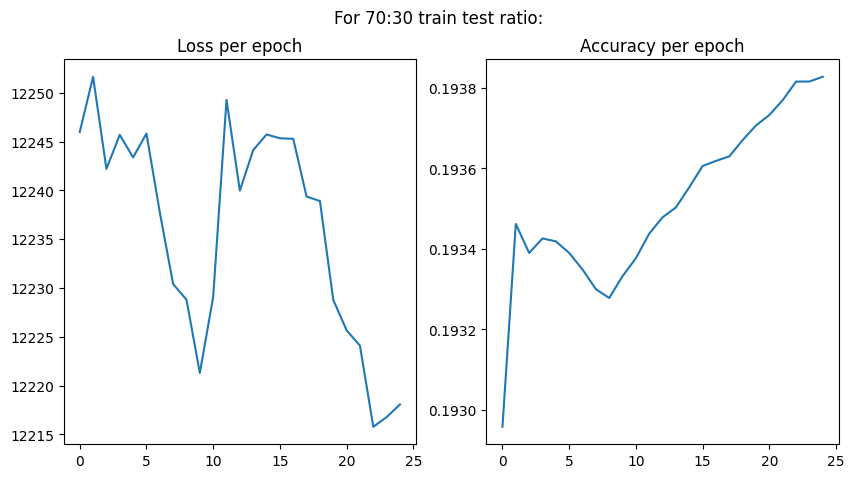

In [ ]:
# Train the network and get the losses and accuracies for 70:30 Train test ratio
losses, accuracies = nn.train(X_train_70, y_train_70, epochs=25, batch_size=23, learning_rate=0.1)
# Plot losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss per epoch')

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Accuracy per epoch')
plt.suptitle("For 70:30 train test ratio:")
plt.show()

0.19841668760995207
0.1991706458909276
0.2005110161682159
0.20290902236742742
0.20761497863784492
0.2128256680908047
0.2177323807130232
0.22180510178436438
0.22507050906145973
0.22788389042472934
0.23020859512440378
0.23226103711150373
0.2340653817155475
0.23563888988619142
0.2370444835385814
0.23825867052023564
0.2393152284789311
0.24028929658485376
0.24116744487507383
0.24196406132194664
0.24270276092342627
0.24342000045695167
0.24409672519860454
0.24471705621178635
0.24529278713245473


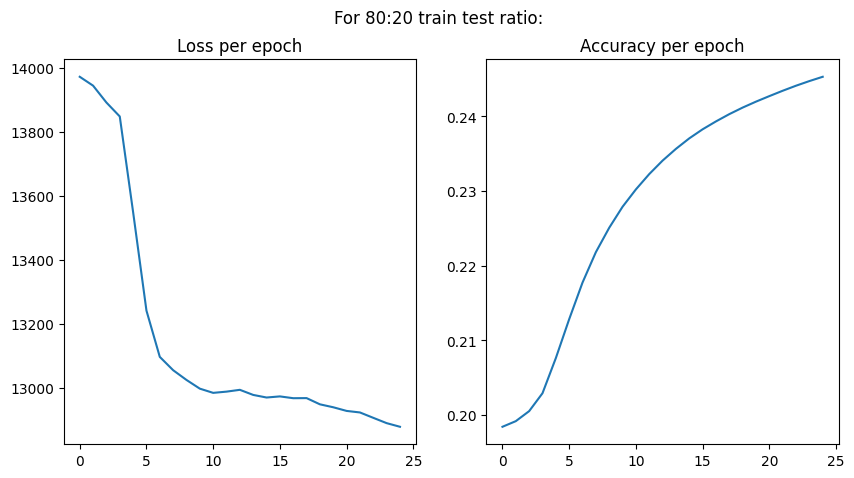

In [ ]:
# Train the network and get the losses and accuracies for 80:20 Train test ratio
losses, accuracies = nn.train(X_train_80, y_train_80, epochs=25, batch_size=23, learning_rate=0.1)
# Plot losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss per epoch')

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Accuracy per epoch')
plt.suptitle("For 80:20 train test ratio:")
plt.show()

0.24237174471890022
0.24270705264334422
0.2428188219514909
0.24270705264333983
0.24293059125963393
0.2428933348235862
0.24293059125963856
0.24302838940427027
0.24301752294375764
0.24302000670616236
0.24307284310637897
0.24309824522186768
0.24311114168050063
0.2431142122658897
0.24312432472710344
0.24311221638538774
0.24314755521075834
0.24313550165791908
0.2431247169001155
0.24317089527216626
0.2431594522239513
0.2431642907221401
0.2431589894110834
0.2431355016579234
0.24311389292501612


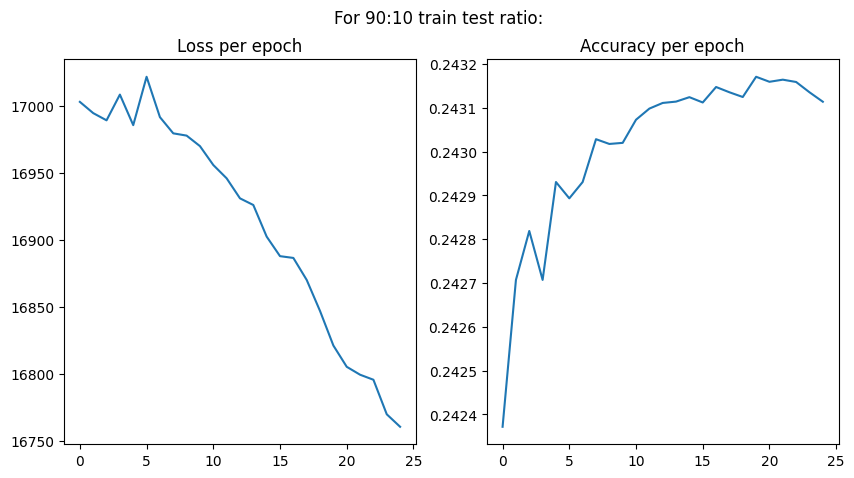

In [ ]:
# Train the network and get the losses and accuracies for 90:10 Train test ratio
losses, accuracies = nn.train(X_train_90, y_train_90, epochs=25, batch_size=23, learning_rate=0.1)
# Plot losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss per epoch')

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Accuracy per epoch')
plt.suptitle("For 90:10 train test ratio:")
plt.show()

**Prepare a Confusion matrix for all the combinations of the network**.

---



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
#Confusion Matrix for 70:30 train test ratio
y_pred = nn.predict(X_test_30)
y_true = np.argmax(y_test_30, axis=1)

cm = confusion_matrix(y_true, y_pred)

labels = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 70:30 train test ratio')
plt.show()

In [ ]:
#Confusion Matrix for 80:20 train test ratio
y_pred = nn.predict(X_test_20)
y_true = np.argmax(y_test_20, axis=1)

cm = confusion_matrix(y_true, y_pred)

labels = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 80:20 train test ratio')
plt.show()

In [ ]:
#Confusion Matrix for 90:10 train test ratio
y_pred = nn.predict(X_test_10)
y_true = np.argmax(y_test_10, axis=1)

cm = confusion_matrix(y_true, y_pred)

labels = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 90:10 train test ratio')
plt.show()

**Report total trainable and non-trainable parameters.**

---



In [ ]:
total_trainable_params = sum(w.size + b.size for w, b in zip(nn.weights.values(), nn.biases.values()))
print("Total Trainable parameters: ", total_trainable_params)

Total Trainable parameters:  111274
